## Install dependencies

In [1]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install pandas_market_calendars

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /private/var/folders/n2/v7krv3hd7f9_j02wpl4_74000000gn/T/pip-req-build-kzdkclmf
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /private/var/folders/n2/v7krv3hd7f9_j02wpl4_74000000gn/T/pip-req-build-kzdkclmf
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 9175621d1235a335a667ee4796d7722e555a9e78
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/n2/v7krv3hd7f9_j02wpl4_74000000gn/T/pip-install-918e4_sw/elegantrl_7e72a9141c354f449112b098096756b3
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/n2/v7krv3hd7f9_j02wpl4_74000000gn/T/pip-install-918e4_sw/elegantrl_7e72a9141c354f449112b098096756b3
  

In [2]:
!pip install yfinance --upgrade --no-cache-dir

  Attempting uninstall: websockets
    Found existing installation: websockets 10.4
    Uninstalling websockets-10.4:
      Successfully uninstalled websockets-10.4
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.58
    Uninstalling yfinance-0.2.58:
      Successfully uninstalled yfinance-0.2.58
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
alpaca-trade-api 3.2.0 requires websockets<11,>=9.0, but you have websockets 15.0.1 which is incompatible.


In [3]:
import yfinance as yf
print(yf.__version__)

0.2.61


## Stage 1: Preprocessing

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime

from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.config import INDICATORS

import itertools

In [5]:
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=600)

start_date = start_date.strftime("%Y-%m-%d")
end_date = end_date.strftime("%Y-%m-%d")

print("Start date: ", start_date)
print("End date: ", end_date)

Start date:  2023-10-07
End date:  2025-05-29


In [6]:
# Download NVDA hourly data
nvda_df_yf = yf.download(
    tickers="NVDA",
    start=start_date,
    end=end_date,
    interval="1h",
)

# Reset index and add 'tic' column for FinRL compatibility
nvda_df_yf.columns = nvda_df_yf.columns.get_level_values(0)
nvda_df_yf.reset_index(inplace=True)
nvda_df_yf.rename(columns={'Datetime': 'date'}, inplace=True)
nvda_df_yf['tic'] = 'NVDA'

# Reorder and rename columns to lowercase
nvda_df_yf = nvda_df_yf.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})

# Add a column for the day of the week (0 = Monday, 6 = Sunday)
nvda_df_yf['day'] = nvda_df_yf['date'].dt.dayofweek

# Optionally filter out weekends (since the market is closed)
nvda_df_yf = nvda_df_yf[nvda_df_yf['day'] < 5]

# Keep only needed columns for FinRL
nvda_df_yf = nvda_df_yf[['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day']]

nvda_df_yf.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,date,open,high,low,close,volume,tic,day
0,2023-10-09 13:30:00+00:00,44.842003,45.049999,44.417999,44.709320,13162929,NVDA,0
1,2023-10-09 14:30:00+00:00,44.719002,44.773903,44.368000,44.510002,4963964,NVDA,0
2,2023-10-09 15:30:00+00:00,44.510002,44.862900,44.500000,44.775002,3473688,NVDA,0
3,2023-10-09 16:30:00+00:00,44.778999,45.110001,44.710999,45.066010,3416864,NVDA,0
4,2023-10-09 17:30:00+00:00,45.075001,45.560997,45.066170,45.419670,6002919,NVDA,0


In [7]:
# Add technical indicators using FinRL's FeatureEngineer
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_vix=False,  # Not available for hourly data
    use_turbulence=False,
    user_defined_feature=False
)

processed = fe.preprocess_data(nvda_df_yf)
processed

Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2023-10-09 13:30:00+00:00,44.842003,45.049999,44.417999,44.709320,13162929,NVDA,0,0.000000,44.891539,44.327783,0.000000,-66.666667,100.000000,44.709320,44.709320
1,2023-10-09 14:30:00+00:00,44.719002,44.773903,44.368000,44.510002,4963964,NVDA,0,-0.004472,44.891539,44.327783,0.000000,-66.666667,100.000000,44.609661,44.609661
2,2023-10-09 15:30:00+00:00,44.510002,44.862900,44.500000,44.775002,3473688,NVDA,0,0.002520,44.940777,44.388772,57.901419,44.154110,31.099133,44.664775,44.664775
3,2023-10-09 16:30:00+00:00,44.778999,45.110001,44.710999,45.066010,3416864,NVDA,0,0.016144,45.225273,44.304894,74.605259,133.333333,76.608151,44.765083,44.765083
4,2023-10-09 17:30:00+00:00,45.075001,45.560997,45.066170,45.419670,6002919,NVDA,0,0.037281,45.604251,44.187751,83.056974,137.832727,89.779198,44.896001,44.896001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,2025-05-28 15:30:00+00:00,135.595001,136.100006,135.479996,135.940308,21989816,NVDA,2,0.699696,137.542433,129.820078,58.739099,97.651842,15.529594,133.609354,134.168434
2850,2025-05-28 16:30:00+00:00,135.934998,136.500000,135.520004,136.449997,22906136,NVDA,2,0.776785,137.886102,129.787907,59.750021,107.701297,19.217884,133.628494,134.186815
2851,2025-05-28 17:30:00+00:00,136.449997,137.250000,136.240005,136.669998,27863769,NVDA,2,0.845879,138.217653,129.731486,60.185595,131.797975,25.718751,133.614660,134.243482
2852,2025-05-28 18:30:00+00:00,136.660004,137.190002,136.315002,136.830002,30892124,NVDA,2,0.903137,138.564400,129.788750,60.507141,124.897397,25.718751,133.735160,134.284232


In [8]:
# Fill missing hourly time gaps
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(), processed['date'].max(), freq='h'))
combination = list(itertools.product(list_date, list_ticker))

processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(processed, on=["date", "tic"], how="left")
processed_full = processed_full.sort_values(['date', 'tic'])
processed_full = processed_full.fillna(0)

In [9]:
columns = [
    'open', 'high', 'low', 'close', 'volume', 'macd',
    'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30',
    'close_30_sma', 'close_60_sma'
]

for col in columns:
    processed_full = processed_full[processed_full[col] != 0]

processed_full = processed_full.reset_index(drop=True)

In [10]:
processed_full.shape

(2849, 16)

In [11]:
# stock market is only open 5 days per week (about 22 days per month), about 6 hours per day.

In [12]:
processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2023-10-09 15:30:00+00:00,NVDA,44.510002,44.862900,44.500000,44.775002,3473688.0,0.0,0.002520,44.940777,44.388772,57.901419,44.154110,31.099133,44.664775,44.664775
1,2023-10-09 16:30:00+00:00,NVDA,44.778999,45.110001,44.710999,45.066010,3416864.0,0.0,0.016144,45.225273,44.304894,74.605259,133.333333,76.608151,44.765083,44.765083
2,2023-10-09 17:30:00+00:00,NVDA,45.075001,45.560997,45.066170,45.419670,6002919.0,0.0,0.037281,45.604251,44.187751,83.056974,137.832727,89.779198,44.896001,44.896001
3,2023-10-09 18:30:00+00:00,NVDA,45.420998,45.605000,45.291000,45.517002,4939165.0,0.0,0.053448,45.810913,44.188089,84.523427,113.562728,90.346123,44.999501,44.999501
4,2023-10-09 19:30:00+00:00,NVDA,45.527992,45.535999,45.174000,45.273003,2921187.0,0.0,0.051842,45.807600,44.269545,69.029300,66.193202,64.423510,45.038573,45.038573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844,2025-05-28 15:30:00+00:00,NVDA,135.595001,136.100006,135.479996,135.940308,21989816.0,2.0,0.699696,137.542433,129.820078,58.739099,97.651842,15.529594,133.609354,134.168434
2845,2025-05-28 16:30:00+00:00,NVDA,135.934998,136.500000,135.520004,136.449997,22906136.0,2.0,0.776785,137.886102,129.787907,59.750021,107.701297,19.217884,133.628494,134.186815
2846,2025-05-28 17:30:00+00:00,NVDA,136.449997,137.250000,136.240005,136.669998,27863769.0,2.0,0.845879,138.217653,129.731486,60.185595,131.797975,25.718751,133.614660,134.243482
2847,2025-05-28 18:30:00+00:00,NVDA,136.660004,137.190002,136.315002,136.830002,30892124.0,2.0,0.903137,138.564400,129.788750,60.507141,124.897397,25.718751,133.735160,134.284232


In [13]:
# Split into train/test
TRAIN_START_DATE = processed_full['date'].min()
TRAIN_END_DATE = processed_full['date'].iloc[int(len(processed_full) * 0.8)]
TRADE_START_DATE = processed_full['date'].iloc[int(len(processed_full) * 0.8) + 1]
TRADE_END_DATE = processed_full['date'].max()

train = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE, TRADE_END_DATE)

print(f'Train start date: {TRAIN_START_DATE}')
print(f'Train end date: {TRAIN_END_DATE}')
print(f'Trade start date: {TRADE_START_DATE}')
print(f'Trade end date: {TRADE_END_DATE}')

print(f"Train size: {len(train)} rows")
print(f"Trade size: {len(trade)} rows")

Train start date: 2023-10-09 15:30:00+00:00
Train end date: 2025-01-30 18:30:00+00:00
Trade start date: 2025-01-30 19:30:00+00:00
Trade end date: 2025-05-28 19:30:00+00:00
Train size: 2279 rows
Trade size: 568 rows


In [14]:
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

## Stage 2: Training

In [15]:
import pandas as pd
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR

In [16]:
train = pd.read_csv('train_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']

### Agent: A2C

In [17]:
# Environment setup
stock_dimension = len(train.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [18]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension  # 0.1% trading cost
num_stock_shares = [0] * stock_dimension

env_kwargs_a2c = {
    "hmax": 500,                         # Max shares to trade per step
    "initial_amount": 100000,           # Lower for intraday
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4             # Smaller for hourly granularity
}

e_train_gym_a2c = StockTradingEnv(df = train, **env_kwargs_a2c)
env_train_a2c, _ = e_train_gym_a2c.get_sb_env()

In [19]:
# Initialize A2C agent
agent_a2c = DRLAgent(env=env_train_a2c)
model_a2c = agent_a2c.get_model("a2c")
# USE mps if available
# model_a2c = agent_a2c.get_model("a2c", model_kwargs={"device": "mps"})

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [42]:
# Train the agent
trained_a2c = agent_a2c.train_model(
    model=model_a2c,
    tb_log_name='a2c_hourly',
    total_timesteps=150000   # Slightly more steps due to smaller interval
)



-----------------------------------------
| time/                 |               |
|    fps                | 1814          |
|    iterations         | 100           |
|    time_elapsed       | 0             |
|    total_timesteps    | 500           |
| train/                |               |
|    entropy_loss       | -3.13         |
|    explained_variance | 1.19e-07      |
|    learning_rate      | 0.0007        |
|    n_updates          | 30099         |
|    policy_loss        | 0.0709        |
|    reward             | 0.00044095764 |
|    std                | 5.53          |
|    value_loss         | 0.00324       |
-----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 1903       |
|    iterations         | 200        |
|    time_elapsed       | 0          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -3.14      |
|    explained_v

In [51]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c")

## agent:ppo


In [96]:
# ---- PPO Agent Training (Place This Cell Before SAC Training) ----
# Import PPO
from stable_baselines3 import PPO

# Set up environment for PPO
buy_cost_list = sell_cost_list = [0.001] * stock_dimension  # 0.1% trading cost
num_stock_shares = [0] * stock_dimension

env_kwargs_ppo = {
    "hmax": 500,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4   # balanced between A2C (1e-10) and SAC (1e-6)
}

In [97]:
e_train_gym_ppo = StockTradingEnv(df=train, **env_kwargs_ppo)
env_train_ppo, _ = e_train_gym_ppo.get_sb_env()

# Initialize PPO agent
agent_ppo = DRLAgent(env=env_train_ppo)

PPO_PARAMS = {
    "n_steps": 2048,
    "batch_size": 128,
    "learning_rate": 0.005,
    "ent_coef": 0.0,
    "clip_range": 0.2,
    "gamma": 0.99,
    "gae_lambda": 0.95,
}

model_ppo = agent_ppo.get_model("ppo", model_kwargs=PPO_PARAMS)



{'n_steps': 2048, 'batch_size': 128, 'learning_rate': 0.005, 'ent_coef': 0.0, 'clip_range': 0.2, 'gamma': 0.99, 'gae_lambda': 0.95}
Using cpu device


In [98]:
# Optional: direct model device to 'mps' (Apple Silicon) or 'cuda' if available
# model_ppo = agent_ppo.get_model("ppo", model_kwargs={**PPO_PARAMS, "device": "cuda"})

tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
model_ppo.set_logger(new_logger_ppo)


Logging to results/ppo


In [99]:
# Train the PPO agent
trained_ppo = agent_ppo.train_model(
    model=model_ppo,
    tb_log_name='ppo_hourly',
    total_timesteps=150000
)



------------------------------------
| time/              |             |
|    fps             | 2462        |
|    iterations      | 1           |
|    time_elapsed    | 0           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.026329635 |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2542        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007010907 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | -2.24       |
|    learning_rate        | 0.005       |
|    loss                 | 0.0527      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00339 

In [100]:
# Save the PPO model
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo")
print("PPO training complete and model saved.")
# ---- End PPO Agent Training ----


PPO training complete and model saved.


### Agent: TD3

In [72]:


# ---- TD3 Agent Training ----
from stable_baselines3 import TD3

env_kwargs_td3 = {
    "hmax": 500,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-6  # Smaller for TD3
}

e_train_gym_td3 = StockTradingEnv(df=train, **env_kwargs_td3)
env_train_td3, _ = e_train_gym_td3.get_sb_env()

obs = env_train_td3.reset()
print(obs)


[[1.0000000e+05 4.4775002e+01 0.0000000e+00 2.5195568e-03 4.4940777e+01
  4.4388771e+01 5.7901421e+01 4.4154110e+01 3.1099133e+01 4.4664776e+01
  4.4664776e+01]]


In [73]:


agent_td3 = DRLAgent(env=env_train_td3)

TD3_PARAMS = {
    "buffer_size":     300_000,
    "batch_size":      256,
    "learning_rate":   1e-4,
    "gamma":           0.99,
    "tau":             0.005,   # soft update
    "policy_delay":    2,       # the “delayed” part
    "target_policy_noise": 0.1,
    "target_noise_clip":  0.3,
}

model_td3 = agent_td3.get_model("td3", model_kwargs={**TD3_PARAMS, "device": "mps"})

tmp_path = RESULTS_DIR + "/td3"
model_td3.set_logger(configure(tmp_path, ["stdout", "csv", "tensorboard"]))



{'buffer_size': 300000, 'batch_size': 256, 'learning_rate': 0.0001, 'gamma': 0.99, 'tau': 0.005, 'policy_delay': 2, 'target_policy_noise': 0.1, 'target_noise_clip': 0.3, 'device': 'mps'}
Using mps device
Logging to results/td3


In [74]:
# train the TD3 agent
trained_td3 = agent_td3.train_model(
    model=model_td3,
    tb_log_name="td3_hourly",
    total_timesteps=150_000,
)


--------------------------------------
| time/              |               |
|    episodes        | 4             |
|    fps             | 97            |
|    time_elapsed    | 93            |
|    total_timesteps | 9116          |
| train/             |               |
|    actor_loss      | 50.9          |
|    critic_loss     | 64.8          |
|    learning_rate   | 0.0001        |
|    n_updates       | 9015          |
|    reward          | 0.00040884461 |
--------------------------------------
day: 2278, episode: 10
begin_total_asset: 100000.00
end_total_asset: 264043.68
total_reward: 164043.68
total_cost: 99.90
total_trades: 2278
Sharpe: 0.663
--------------------------------------
| time/              |               |
|    episodes        | 8             |
|    fps             | 99            |
|    time_elapsed    | 183           |
|    total_timesteps | 18232         |
| train/             |               |
|    actor_loss      | 44.4          |
|    critic_loss     | 23.4

In [75]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3")
print("TD3 training complete.")
# ---- End TD3 Agent Training ----


TD3 training complete.


### Agent: SAC

In [117]:
# ---- SAC Agent Training ----
from stable_baselines3 import SAC

env_kwargs_sac = {
    "hmax": 500,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-8  # Smaller for SAC
}

e_train_gym_sac = StockTradingEnv(df=train, **env_kwargs_sac)
env_train_sac, _ = e_train_gym_sac.get_sb_env()
agent_sac = DRLAgent(env=env_train_sac)



In [118]:
# SAC_PARAMS = {
#     "buffer_size":     300_000,
#     "batch_size":      256,
#     "learning_rate":   1e-4,
#     "gamma":           0.99,
#     "tau":             0.005,   # soft update
#     "ent_coef":        "auto",  # automatic entropy coefficient
# }

SAC_PARAMS = {
    "buffer_size":   500_000,
    "batch_size":    256,
    "learning_rate": 1e-4,
    "tau":           0.005,
    "gamma":         0.99,
    "ent_coef":      "auto_0.1",                       # tame α
    "target_update_interval": 1,
    "target_entropy": -0.5 * stock_dimension,          # half the default,
}

env_kwargs_sac["reward_scaling"] = 1e-8              # bigger signal

In [119]:
model_sac = agent_sac.get_model("sac", model_kwargs=SAC_PARAMS)
model_sac.set_logger(configure(RESULTS_DIR + "/sac", ["stdout", "csv", "tensorboard"]))



{'buffer_size': 500000, 'batch_size': 256, 'learning_rate': 0.0001, 'tau': 0.005, 'gamma': 0.99, 'ent_coef': 'auto_0.1', 'target_update_interval': 1, 'target_entropy': -0.5}
Using cpu device
Logging to results/sac


In [120]:
trained_sac = agent_sac.train_model(
    model=model_sac,
    tb_log_name="sac_hourly",
    total_timesteps=150_000,
)

-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 209          |
|    time_elapsed    | 43           |
|    total_timesteps | 9116         |
| train/             |              |
|    actor_loss      | 88.5         |
|    critic_loss     | 3.46         |
|    ent_coef        | 0.245        |
|    ent_coef_loss   | 13.9         |
|    learning_rate   | 0.0001       |
|    n_updates       | 9015         |
|    reward          | 4.088446e-06 |
-------------------------------------
-------------------------------------
| time/              |              |
|    episodes        | 8            |
|    fps             | 202          |
|    time_elapsed    | 89           |
|    total_timesteps | 18232        |
| train/             |              |
|    actor_loss      | 227          |
|    critic_loss     | 2.89         |
|    ent_coef        | 0.61         |
|    ent_coef_loss   | 4.9          |
|    learnin

In [121]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac")
print("SAC training complete.")
# ---- End SAC Agent Training ----

SAC training complete.


In [122]:
# sb3 version check
import stable_baselines3 as sb3
print("Stable Baselines3 version:", sb3.__version__)

Stable Baselines3 version: 2.6.0


In [ ]:


# # ---- Ensemble Agent Evaluation (Place This Cell After Individual Agent Backtests) ----
# # This cell aggregates A2C, PPO, TD3, and SAC into a single trading policy and evaluates it on the back-test set.

# from finrl.meta.algorithms.ensemble.ensemble_agent import EnsembleAgent
# import torch

# # 1️⃣ Map agent names to checkpoint paths
# MODEL_PATHS = {
#     "a2c": f"{TRAINED_MODEL_DIR}/a2c_hourly.zip",
#     "ppo": f"{TRAINED_MODEL_DIR}/ppo_hourly.zip",
#     "td3": f"{TRAINED_MODEL_DIR}/td3_hourly.zip",
#     "sac": f"{TRAINED_MODEL_DIR}/sac_hourly.zip",
# }

# # 2️⃣ Create the trading environment for the out-of-sample period
# trade_env_kwargs = {
#     **env_kwargs_base,
#     "hmax": 500,
#     "initial_amount": 100000,
#     "reward_scaling": 1.0,   # turn off scaling during inference
# }

# e_trade_gym = StockTradingEnv(df=trade, **trade_env_kwargs)
# env_trade, _ = e_trade_gym.get_sb_env()

# # 3️⃣ Instantiate the ensemble agent
# ensemble_agent = EnsembleAgent(
#     model_path_dict = MODEL_PATHS,
#     trading_env     = env_trade,
#     action_choice   = "mean",   # average position vectors; alternatives: 'vote', 'median'
#     weight_scheme   = None,      # equal weights; inject a dict for custom weighting
#     device          = "cuda" if torch.cuda.is_available() else "cpu",
# )

# # 4️⃣ Run the ensemble and collect results

# df_actions, df_daily_return, sharpe_ensemble = ensemble_agent.run()

# print(f"Ensemble Sharpe: {sharpe_ensemble:.3f}")
# print(df_daily_return.tail())

# # Optional: save the daily returns and actions for later analysis
# # df_daily_return.to_csv(RESULTS_DIR + '/ensemble_daily_return.csv', index=False)
# # df_actions.to_csv(RESULTS_DIR + '/ensemble_actions.csv', index=False)

# # ---- End Ensemble Agent Evaluation ----

## Stage 3: Backtesting

### Load trade dataset and trained models

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, SAC
from pypfopt.efficient_frontier import EfficientFrontier
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from gymnasium import spaces

%matplotlib inline

In [124]:
trade = pd.read_csv('trade_data.csv')

trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [125]:
trade.head(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
,,,,,,,,,,,,,,,,
0,2025-01-30 19:30:00+00:00,NVDA,121.454300,123.480003,121.000000,123.415001,43926561.0,3.0,-2.774938,128.794814,117.174675,42.739277,-20.597300,11.036733,124.085014,133.720442
1,2025-01-30 20:30:00+00:00,NVDA,123.410004,125.000000,121.930000,124.910004,47647645.0,3.0,-2.330719,128.983218,117.300272,44.619571,8.934958,3.017605,123.505010,133.502800
2,2025-01-31 14:30:00+00:00,NVDA,123.809998,126.629997,123.209999,126.185997,84699752.0,4.0,-1.854336,129.293092,117.531998,46.179995,53.663809,4.858950,122.976710,133.301567
3,2025-01-31 15:30:00+00:00,NVDA,126.180000,127.849998,125.750000,126.750000,58838231.0,4.0,-1.414977,129.406299,117.491792,46.864579,119.064229,10.343532,122.448363,133.112567
4,2025-01-31 16:30:00+00:00,NVDA,126.739998,126.970001,124.059998,125.309998,44879038.0,4.0,-1.169496,129.304382,117.515709,45.341291,82.551241,1.665155,122.491030,132.906317


In [126]:
# Load the pre-trained model
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c")
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac")
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo")
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3")

### Load sentiment risk scores

In [127]:
## Load aggregated_risk_scores
sentiment_df = pd.read_csv('aggregated_risk_scores.csv')

# Rename columns for consistency
sentiment_df = sentiment_df.rename(columns={"datetime": "date", "avg_weighted_score": "risk_score"})

# Convert to datetime and localize to UTC
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.tz_localize('UTC')

In [128]:
sentiment_df.head(5)

,date,risk_score
0,2025-03-15 17:30:00+00:00,4
1,2025-03-16 12:30:00+00:00,3
2,2025-03-17 19:30:00+00:00,3
3,2025-03-17 23:30:00+00:00,5
4,2025-03-18 18:30:00+00:00,4


In [129]:
# Merge with UTC-aligned trade['date']
trade_copy = trade.copy()
trade_copy['date'] = pd.to_datetime(trade_copy['date'], utc=True)
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], utc=True)
trade_sentiment = pd.merge(trade_copy, sentiment_df, on='date', how='left')

# Fill missing risk scores with 0
trade_sentiment['risk_score'] = trade_sentiment['risk_score'].fillna(0)

trade_sentiment.head(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,risk_score
0,2025-01-30 19:30:00+00:00,NVDA,121.454300,123.480003,121.000000,123.415001,43926561.0,3.0,-2.774938,128.794814,117.174675,42.739277,-20.597300,11.036733,124.085014,133.720442,0.0
1,2025-01-30 20:30:00+00:00,NVDA,123.410004,125.000000,121.930000,124.910004,47647645.0,3.0,-2.330719,128.983218,117.300272,44.619571,8.934958,3.017605,123.505010,133.502800,0.0
2,2025-01-31 14:30:00+00:00,NVDA,123.809998,126.629997,123.209999,126.185997,84699752.0,4.0,-1.854336,129.293092,117.531998,46.179995,53.663809,4.858950,122.976710,133.301567,0.0
3,2025-01-31 15:30:00+00:00,NVDA,126.180000,127.849998,125.750000,126.750000,58838231.0,4.0,-1.414977,129.406299,117.491792,46.864579,119.064229,10.343532,122.448363,133.112567,0.0
4,2025-01-31 16:30:00+00:00,NVDA,126.739998,126.970001,124.059998,125.309998,44879038.0,4.0,-1.169496,129.304382,117.515709,45.341291,82.551241,1.665155,122.491030,132.906317,0.0


### Prediction for Agent 1's

In [130]:
# Setup the environment
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension

In [131]:
BASE_ENV_KWARGS = {
    "initial_amount": 1_000_000,
    "buy_cost_pct": [0.001],
    "sell_cost_pct": [0.001],
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "stock_dim": stock_dimension,
    "state_space": state_space,
    "num_stock_shares": [0] * stock_dimension,
}

In [132]:
# agent specific overrides

AGENT_ENV_OVERRIDES = {
    "a2c": {
        "reward_scaling": 1e-4,
        "hmax": 500,
    },
    "ppo": {
        "reward_scaling": 1e-4,
        "hmax": 500,
    },
    "sac": {
        "reward_scaling": 1e-10,
        "hmax": 1000,
    },
    "td3": {
        "reward_scaling": 1e-10,
        "hmax": 1000,
    }
}

In [133]:
def get_env_kwargs(agent_name: str):
    env_kwargs = BASE_ENV_KWARGS.copy()
    env_kwargs.update(AGENT_ENV_OVERRIDES[agent_name.lower()])
    return env_kwargs

env_kwargs_a2c = get_env_kwargs("a2c")
env_kwargs_ppo = get_env_kwargs("ppo")
env_kwargs_sac = get_env_kwargs("sac")
env_kwargs_td3 = get_env_kwargs("td3")

In [134]:
e_train_gym_a2c = StockTradingEnv(df=trade, **env_kwargs_a2c)
e_train_gym_ppo = StockTradingEnv(df=trade, **env_kwargs_ppo)
e_train_gym_sac = StockTradingEnv(df=trade, **env_kwargs_sac)
e_train_gym_td3 = StockTradingEnv(df=trade, **env_kwargs_td3)

In [135]:
env_train_a2c, _ = e_train_gym_a2c.get_sb_env()
env_train_ppo, _ = e_train_gym_ppo.get_sb_env()
env_train_sac, _ = e_train_gym_sac.get_sb_env()
env_train_td3, _ = e_train_gym_td3.get_sb_env()

In [136]:
df_account_value_a2c_agent1, df_actions_a2c_agent1 = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment=e_train_gym_a2c
)
df_account_value_ppo_agent1, df_actions_ppo_agent1 = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment=e_train_gym_ppo
)
df_account_value_sac_agent1, df_actions_sac_agent1 = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment=e_train_gym_sac
)
df_account_value_td3_agent1, df_actions_td3_agent1 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment=e_train_gym_td3
)

hit end!
hit end!
hit end!
hit end!


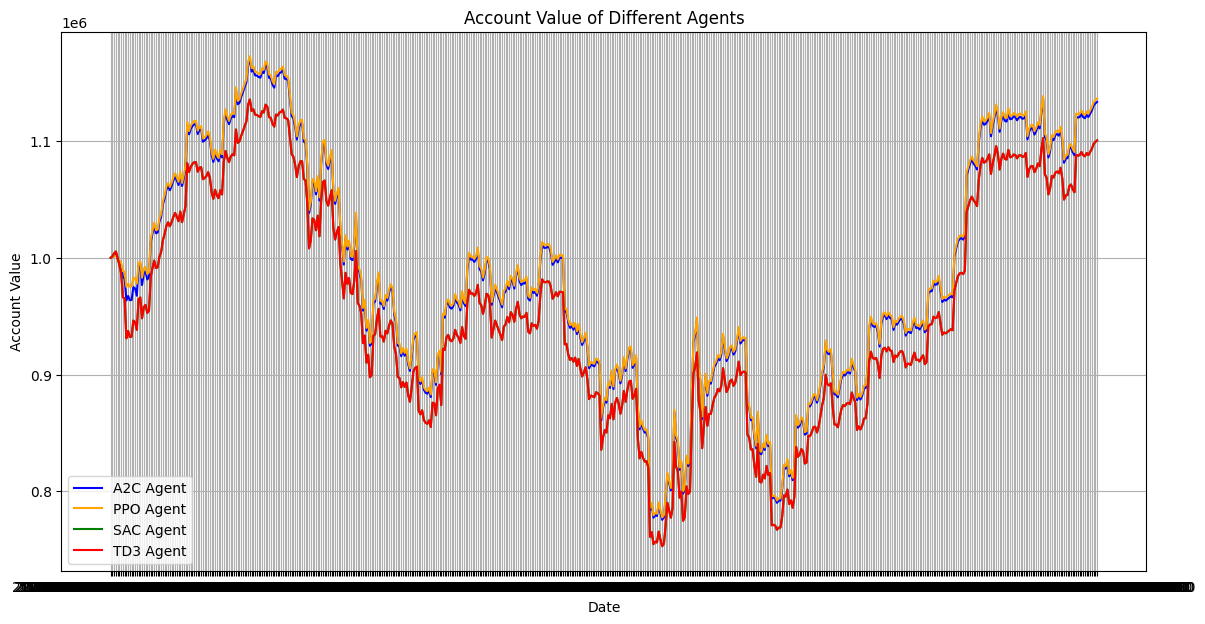

In [140]:
#plot the account value
plt.figure(figsize=(14, 7))
plt.plot(df_account_value_a2c_agent1['date'], df_account_value_a2c_agent1['account_value'], label='A2C Agent', color='blue')
plt.plot(df_account_value_ppo_agent1['date'], df_account_value_ppo_agent1['account_value'], label='PPO Agent', color='orange')
plt.plot(df_account_value_sac_agent1['date'], df_account_value_sac_agent1['account_value'], label='SAC Agent', color='green')
plt.plot(df_account_value_td3_agent1['date'], df_account_value_td3_agent1['account_value'], label='TD3 Agent', color='red')
plt.title('Account Value of Different Agents')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.legend()
plt.grid()
plt.show()

### Prediction for Agent 2

#### custom trading environment

In [141]:
# custom trading environment

class RiskAwareStockTradingEnv(StockTradingEnv):
    def __init__(self, df, **kwargs):
        self.risk_score_col = 'risk_score'
        super().__init__(df, **kwargs)

    def step(self, actions):
        state, reward, done, truncated, info = super().step(actions)

        day_idx = max(0, self.day - 1)
        risk_score = self.df.loc[day_idx, self.risk_score_col] if self.risk_score_col in self.df.columns else 0
        risk_score = risk_score if pd.notnull(risk_score) else 0

        risk_weight = self._get_risk_scaling_factor(risk_score)

        state[0] = state[0] * risk_weight

        return state, reward, done, truncated, info

    def _get_risk_scaling_factor(self, risk_score):
        if risk_score == 0:
            return 1  # No change
        elif 1 <= risk_score <= 2:
            return 1.5  # More optimistic
        elif risk_score == 3:
            return 1.0  # Slight optimistic
        elif 4 <= risk_score <= 5:
            return -0.5  # Slight caution
        else:
            return 1


#### A2C Agent 2

In [142]:
# Setup the environment
stock_dimension_agent2 = len(trade.tic.unique())
state_space_agent2 = 1 + 2 * stock_dimension_agent2 + len(INDICATORS) * stock_dimension_agent2

In [143]:
env_kwargs_agent2 = {
    "hmax": 500,
    "initial_amount": 1000000,
    "num_stock_shares": [0] * stock_dimension_agent2,
    "buy_cost_pct": [0.001] * stock_dimension_agent2,
    "sell_cost_pct": [0.001] * stock_dimension_agent2,
    "state_space": state_space_agent2,
    "stock_dim": stock_dimension_agent2,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension_agent2,
    "reward_scaling": 1e-6,
}

# Initialize custom environment with trade_sentiment data
e_trade_sentiment = RiskAwareStockTradingEnv(df=trade_sentiment, **env_kwargs_agent2)

# Create the Stable-Baselines compatible wrapper
env_trade_sentiment, _ = e_trade_sentiment.get_sb_env()

In [144]:
df_account_value_a2c_agent2, df_actions_a2c_agent2 = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment=e_trade_sentiment
)

hit end!


#### SAC Agent 2

In [145]:
df_account_value_sac_agent2, df_actions_sac_agent2 = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment=e_trade_sentiment
)

hit end!


In [146]:
df_account_value_ppo_agent2, df_actions_ppo_agent2 = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment=e_trade_sentiment
)

hit end!


In [147]:
df_account_value_td3_agent2, df_actions_td3_agent2 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment=e_trade_sentiment
)

hit end!


### MVO and DJIA

In [148]:
# Convert trade data into MVO format
def process_df_for_mvo(df):
    df = df.sort_values(['date', 'tic'], ignore_index=True)[['date', 'tic', 'close']]
    df['date'] = pd.to_datetime(df['date'], utc=True)
    tickers = df['tic'].unique()
    mvo = pd.DataFrame(columns=tickers)

    for i in range(df.shape[0] // len(tickers)):
        temp = df.iloc[i * len(tickers):(i + 1) * len(tickers)]
        date = temp['date'].iloc[0]
        mvo.loc[date] = temp['close'].values

    mvo.index = pd.to_datetime(mvo.index, utc=True)
    return mvo

In [149]:
StockData = process_df_for_mvo(trade)
arStockPrices = StockData.to_numpy()
rows, cols = arStockPrices.shape

In [150]:
def StockReturnsComputing(StockPrice, Rows, Columns):
    StockReturn = np.zeros([Rows - 1, Columns])
    for j in range(Columns):
        for i in range(Rows - 1):
            StockReturn[i, j] = ((StockPrice[i + 1, j] - StockPrice[i, j]) / StockPrice[i, j]) * 100
    return StockReturn

In [151]:
arReturns = StockReturnsComputing(arStockPrices, rows, cols)
meanReturns = np.mean(arReturns, axis=0).reshape(-1)
covReturns = np.cov(arReturns, rowvar=False) + np.eye(cols) * 1e-6

In [152]:
print("Mean Returns:", meanReturns)
print("Covariance Matrix:", covReturns)

Mean Returns: [0.02802422]
Covariance Matrix: [[1.96736985]]


In [153]:
# Efficient Frontier
ef = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 1))
weights = ef.min_volatility() if stock_dimension == 1 else ef.max_sharpe(solver="SCS")

cleaned_weights_mean = ef.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(stock_dimension)])

In [154]:
mvo_weights

array([1000000.])

In [155]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([7308.33871679])

In [156]:
TradeData = process_df_for_mvo(trade)
TradeData.to_numpy()

Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])

In [157]:
# Benchmark: Hourly DJI
TRADE_START_DATE = trade["date"].iloc[0]
TRADE_END_DATE = trade["date"].iloc[-1]

TRADE_START_DATE = pd.to_datetime(TRADE_START_DATE)
TRADE_END_DATE = pd.to_datetime(TRADE_END_DATE)

trade_start_date = TRADE_START_DATE.strftime("%Y-%m-%d")
trade_end_date = TRADE_END_DATE.strftime("%Y-%m-%d")

# Download DJIA hourly data between TRADE_START_DATE and TRADE_END_DATE
df_dji = yf.download(
    tickers="^DJI",  # DJIA Index ticker
    start=trade_start_date,
    end=trade_end_date,
    interval="1h",
)

# Reset index and rename columns to match desired format
df_dji = df_dji.reset_index()
df_dji = df_dji.rename(columns={'Datetime': 'date'})
df_dji['date'] = pd.to_datetime(df_dji['date'], utc=True)
df_dji['tic'] = '^DJI'

# Reorder and rename columns to lowercase (to match NVDA format)
df_dji = df_dji.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})

# Add a column for the day of the week (0 = Monday, 6 = Sunday)
df_dji['day'] = df_dji['date'].dt.dayofweek

# Filter out weekends (market is closed)
df_dji = df_dji[df_dji['day'] < 5]  # Only weekdays

[*********************100%***********************]  1 of 1 completed


In [158]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'].iloc[0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')

### Merge Results

In [159]:
def ensure_utc_index(df):
    df.index = pd.to_datetime(df.index, utc=True)
    return df

In [160]:
df_result_a2c_agent1 = ensure_utc_index(df_account_value_a2c_agent1.set_index(df_account_value_a2c_agent1.columns[0]))
df_result_a2c_agent1.columns = ['a2c_agent1']

df_result_a2c_agent2 = ensure_utc_index(df_account_value_a2c_agent2.set_index(df_account_value_a2c_agent2.columns[0]))
df_result_a2c_agent2.columns = ['a2c_agent2']

df_result_sac_agent1 = ensure_utc_index(df_account_value_sac_agent1.set_index(df_account_value_sac_agent1.columns[0]))
df_result_sac_agent1.columns = ['sac_agent1']

df_result_sac_agent2 = ensure_utc_index(df_account_value_sac_agent2.set_index(df_account_value_sac_agent2.columns[0]))
df_result_sac_agent2.columns = ['sac_agent2']

df_result_ppo_agent1 = ensure_utc_index(df_account_value_ppo_agent1.set_index(df_account_value_ppo_agent1.columns[0]))
df_result_ppo_agent1.columns = ['ppo_agent1']

df_result_ppo_agent2 = ensure_utc_index(df_account_value_ppo_agent2.set_index(df_account_value_ppo_agent2.columns[0]))
df_result_ppo_agent2.columns = ['ppo_agent2']

df_result_td3_agent1 = ensure_utc_index(df_account_value_td3_agent1.set_index(df_account_value_td3_agent1.columns[0]))
df_result_td3_agent1.columns = ['td3_agent1']

df_result_td3_agent2 = ensure_utc_index(df_account_value_td3_agent2.set_index(df_account_value_td3_agent2.columns[0]))
df_result_td3_agent2.columns = ['td3_agent2']

MVO_result.columns = ['mvo']
dji.columns = ['dji']

result = pd.DataFrame()

# Merge
result = df_result_a2c_agent1.copy()
result = result.join(df_result_a2c_agent2, how='outer')
result = result.join(df_result_sac_agent1, how='outer')
result = result.join(df_result_sac_agent2, how='outer')
result = result.join(df_result_ppo_agent1, how='outer')
result = result.join(df_result_ppo_agent2, how='outer')
result = result.join(df_result_td3_agent1, how='outer')
result = result.join(df_result_td3_agent2, how='outer')
result = result.join(MVO_result, how='outer')
result = result.join(dji, how='outer')

# Fill missing values by backfilling
result = result.fillna(method='bfill')

/var/folders/n2/v7krv3hd7f9_j02wpl4_74000000gn/T/ipykernel_51059/212501495.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = result.fillna(method='bfill')


In [161]:
col_name = ['A2C Agent 1', 'A2C Agent 2', 'SAC Agent 1', 'SAC Agent 2',
           'PPO Agent 1', 'PPO Agent 2', 'TD3 Agent 1', 'TD3 Agent 2',
           'Mean Var', 'djia']
# col_name = ['A2C Agent 1', 'A2C Agent 2', 'SAC Agent 1', 'SAC Agent 2', 'Mean Var', 'djia']
# col_name = ['A2C Agent 1', 'A2C Agent 2']
result.columns = col_name
result = result.dropna(subset=['djia'])
result

,A2C Agent 1,A2C Agent 2,SAC Agent 1,SAC Agent 2,PPO Agent 1,PPO Agent 2,TD3 Agent 1,TD3 Agent 2,Mean Var,djia
date,,,,,,,,,,
2025-01-30 14:30:00+00:00,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,901958.629423,1.000000e+06
2025-01-30 15:30:00+00:00,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,901958.629423,1.000904e+06
2025-01-30 16:30:00+00:00,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,901958.629423,1.000634e+06
2025-01-30 17:30:00+00:00,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,901958.629423,1.003768e+06
2025-01-30 18:30:00+00:00,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,901958.629423,1.004463e+06
...,...,...,...,...,...,...,...,...,...,...
2025-05-27 15:30:00+00:00,1.120570e+06,1.115933e+06,1.087918e+06,1.115933e+06,1.123398e+06,1.118774e+06,1.087918e+06,1.115933e+06,988540.463335,9.435359e+05
2025-05-27 16:30:00+00:00,1.123370e+06,1.118722e+06,1.090636e+06,1.118722e+06,1.126205e+06,1.121569e+06,1.090636e+06,1.118722e+06,991010.774603,9.441575e+05
2025-05-27 17:30:00+00:00,1.120484e+06,1.115847e+06,1.087834e+06,1.115847e+06,1.123312e+06,1.118688e+06,1.087834e+06,1.115847e+06,988464.520667,9.454273e+05


In [162]:
result.to_csv('result.csv')

<Figure size 1500x500 with 0 Axes>

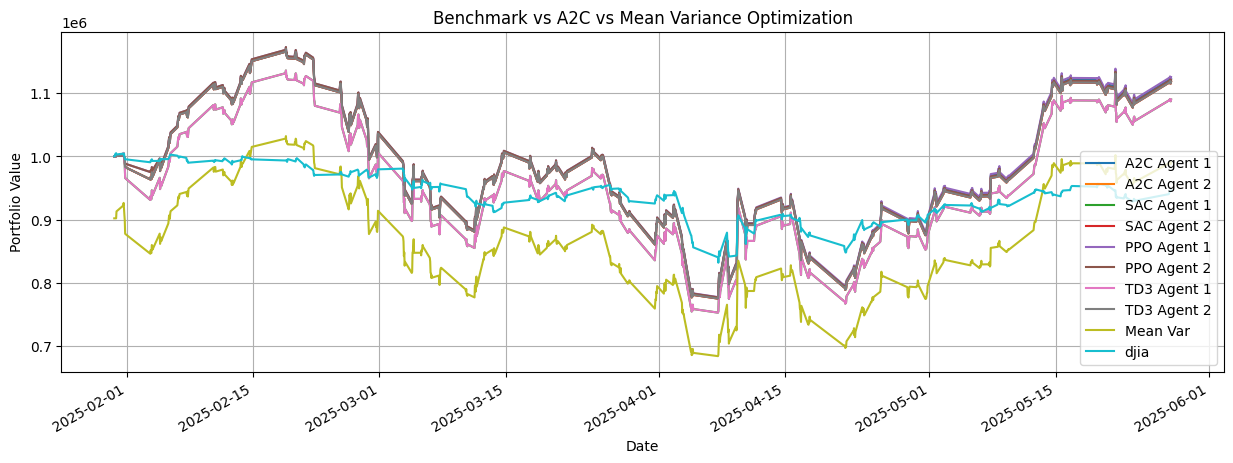

In [163]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
result = pd.read_csv('result.csv')

# Set date as index and convert to datetime
result['date'] = pd.to_datetime(result['date'], utc=True)
result = result.set_index('date').sort_index()

# Plot portfolio values
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
result.plot()
plt.title("Benchmark vs A2C vs Mean Variance Optimization")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend(loc="best")
plt.grid(True)
plt.show()